In [1]:
import numpy as np
import pandas as pd
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def load_file(filepath):
    dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values

# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    # stack group so that features are the 3rd dimension
    loaded = np.dstack(loaded)
    return loaded

    # load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    # load all 9 files as a single array
    filenames = list()
    # total acceleration
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    # body acceleration
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    # body gyroscope
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
    # load input data
    X = load_group(filenames, filepath)
    # load class output
    y = load_file(prefix + group + '/y_'+group+'.txt')
    return X, y

In [3]:
# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
    # load all train
    trainX, trainy = load_dataset_group('train', prefix + '/content/drive/MyDrive/Colab Notebooks/기계학습 10주차/UCI HAR Dataset/')
    # load all test
    testX, testy = load_dataset_group('test', prefix + '/content/drive/MyDrive/Colab Notebooks/기계학습 10주차/UCI HAR Dataset/')

    #zero-offset class values
    trainy = trainy - 1
    testy = testy - 1
    #one hot encode y
    trainy_one_hot = to_categorical(trainy)
    testy_one_hot = to_categorical(testy)
    print(trainX.shape, trainy.shape, trainy_one_hot.shape, testX.shape, testy.shape, testy_one_hot.shape)
    return trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot

In [4]:
trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot = load_dataset()

from sklearn.model_selection import train_test_split

X_train,X_val,y_train_one_hot,y_val_one_hot,y_train,y_val=train_test_split(trainX, trainy_one_hot, trainy,test_size=0.2,random_state=100)

X_train.shape,X_val.shape,y_train_one_hot.shape,y_val_one_hot.shape,y_train.shape,y_val.shape

/tmp/ipython-input-1874727740.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-1874727740.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-1874727740.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-1874727740.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)


(7352, 128, 9) (7352, 1) (7352, 6) (2947, 128, 9) (2947, 1) (2947, 6)


((5881, 128, 9), (1471, 128, 9), (5881, 6), (1471, 6), (5881, 1), (1471, 1))

In [5]:
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train_one_hot.shape[1]


In [8]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (
    Input, Dense, Flatten, Dropout,
    Conv1D, MaxPooling1D, LSTM, concatenate
)
from tensorflow.keras.utils import to_categorical

##Level_1
# layer 1
inputs= Input(shape=(n_timesteps,n_features))##128,9
LSTM1 = LSTM(128,return_sequences=True)(inputs)##128,128,
# merge1
merged_1 = Dropout(0.2)(LSTM1)

##Level_2
# layer 1
LSTM2 = LSTM(64,return_sequences=True)(merged_1)
# merge2
merged_2 = Dropout(0.2)(LSTM2)

##Level_3
# layer 1
LSTM3 = LSTM(32,return_sequences=False)(merged_2)

##dense layer
dense = Dense(512, activation='relu')(LSTM3)
outputs = Dense(n_outputs, activation='softmax')(dense)

##MODEL
LSTM_model = Model(inputs, outputs)

LSTM_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
LSTM_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128, 9)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 128, 128)       │        70,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 128, 64)        │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │         3,078 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 152,454 (595.52 KB)

 Trainable params: 152,454 (595.52 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
model_history=LSTM_model.fit(x=X_train, y=y_train_one_hot, epochs=30, batch_size=32,validation_split=0.1)


Epoch 1/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - accuracy: 0.5203 - loss: 1.1895 - val_accuracy: 0.7301 - val_loss: 0.6578
Epoch 2/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.7460 - loss: 0.5909 - val_accuracy: 0.7980 - val_loss: 0.4991
Epoch 3/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.8180 - loss: 0.4712 - val_accuracy: 0.9270 - val_loss: 0.2272
Epoch 4/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.8943 - loss: 0.3029 - val_accuracy: 0.9321 - val_loss: 0.1658
Epoch 5/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.9353 - loss: 0.1789 - val_accuracy: 0.9457 - val_loss: 0.1245
Epoch 6/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.9326 - loss: 0.1774 - val_accuracy: 0.9525 - val_loss: 0.1306
Epoch 7/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.9405 - loss: 0.1592 - val_accuracy: 0.9457 - val_loss: 0.1274
Epoch 8/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.9528 - loss: 0.1228 - val_acc

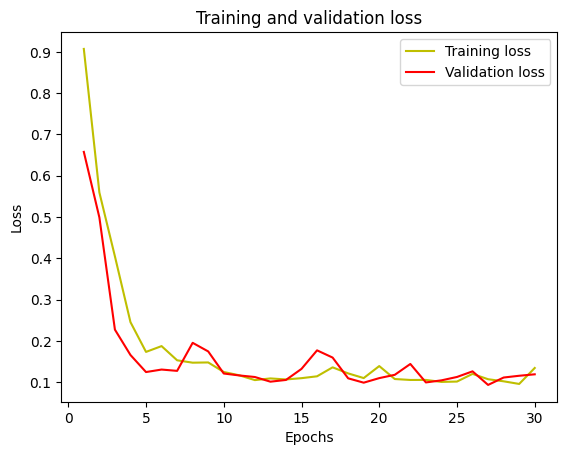

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

loss =model_history.history['loss']
val_loss =model_history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

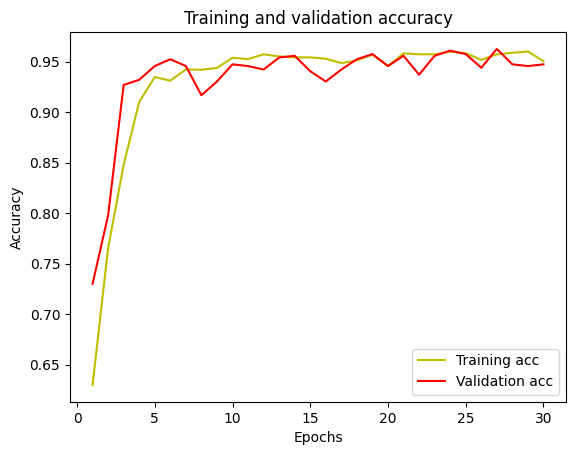

In [11]:
acc =model_history.history['accuracy']
val_acc =model_history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()